# V6

### Daily Calculation:

- The inflation rate is calculated daily in the dynamic_inflation function.
- The supply is updated daily in the calculate_supply_dynamic_daily function.

### Aggregation:

- The aggregate_data function aggregates the daily data into monthly or annual intervals for visualization purposes.

### Plotting:

- The plot_supply_and_inflation function plots the aggregated data based on the selected interval (daily, monthly, or annually).

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import FloatSlider, interact, DatePicker, Dropdown
import datetime


### Constants

In [33]:
# Define color scheme
PRIMARY_COLOR = '#2dff73'
SECONDARY_COLOR = '#3a8d1d'
DARK_COLOR = '#000000'
LIGHT_COLOR = '#ffffff'
ACCENT_COLOR = '#1f1f1f'

initial_supply = 1e9
max_supply = 1e10
daily_inflation_decay_constant = 0.00046  # Approx 17% annual decay
tge_date = datetime.datetime(2024, 9, 1)


In [34]:
# Dynamically adjusted inflation function
def dynamic_inflation(current_supply, max_supply, daily_decay_constant):
    remaining_supply_ratio = (max_supply - current_supply) / max_supply
    inflation_rate = daily_decay_constant * remaining_supply_ratio
    return inflation_rate

# Function to calculate supply based on dynamic inflation rate daily
def calculate_supply_dynamic_daily(initial_supply, max_supply, daily_decay_constant, total_days):
    supply = [initial_supply]
    inflation_rates = []
    for t in range(1, total_days + 1):
        current_supply = supply[-1]
        inflation_rate = dynamic_inflation(current_supply, max_supply, daily_decay_constant)
        inflation_rates.append(inflation_rate)
        new_supply = current_supply * (1 + inflation_rate)
        supply.append(min(new_supply, max_supply))
    return np.array(supply), inflation_rates

# Function to create the DataFrame with daily calculations
def create_emission_schedule_df(initial_supply, max_supply, daily_decay_constant, time_horizon, tge_date):
    total_days = int(time_horizon * 30)  # assuming 30 days per month for simplicity
    supply_dynamic, inflation_rates = calculate_supply_dynamic_daily(initial_supply, max_supply, daily_decay_constant, total_days)

    dates = [tge_date + datetime.timedelta(days=i) for i in range(total_days + 1)]

    data = {
        'Total Supply': supply_dynamic,
        'Inflation Rate': [0] + inflation_rates,  # Adding 0 inflation rate for the initial period
        'Date': [date.strftime("%Y-%m-%d") for date in dates]
    }
    df = pd.DataFrame(data, index=np.arange(0, total_days + 1), columns=['Total Supply', 'Inflation Rate', 'Date'])
    df.index.name = 'Day'
    return df

# Function to aggregate data based on the interval and normalize inflation rate
def aggregate_data(df, interval):
    if interval == 'monthly':
        df['Month'] = (df.index // 30) + 1
        agg_df = df.groupby('Month').agg({
            'Total Supply': 'last',
            'Inflation Rate': lambda x: (1 + x).prod() - 1,
            'Date': 'last'
        })
        agg_df.index.name = 'Month'
        return agg_df
    elif interval == 'annually':
        df['Year'] = (df.index // 365) + 1
        agg_df = df.groupby('Year').agg({
            'Total Supply': 'last',
            'Inflation Rate': lambda x: (1 + x).prod() - 1,
            'Date': 'last'
        })
        agg_df.index.name = 'Year'
        return agg_df
    else:  # daily
        return df

### Plot

In [35]:
# Plotting the Total Supply and Inflation Rate
def plot_supply_and_inflation(df, interval):
    supply_dynamic = df['Total Supply']
    inflation_rates = df['Inflation Rate']
    periods = df.index

    fig, ax1 = plt.subplots(figsize=(14, 8))

    ax1.set_xlabel('Periods', color=LIGHT_COLOR)
    ax1.set_ylabel('Total Supply', color=PRIMARY_COLOR)
    ax1.plot(periods, supply_dynamic, label='Total Supply', color=PRIMARY_COLOR)
    ax1.tick_params(axis='y', labelcolor=PRIMARY_COLOR)
    ax1.tick_params(axis='x', labelcolor=LIGHT_COLOR)
    ax1.axhline(y=max_supply, color=SECONDARY_COLOR, linestyle='--', label='Max Supply')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Inflation Rate', color=LIGHT_COLOR)
    ax2.plot(periods, inflation_rates, label='Inflation Rate', color=LIGHT_COLOR)
    ax2.tick_params(axis='y', labelcolor=LIGHT_COLOR)
    ax2.axhline(y=0, color='blue', linestyle='--', label='Zero Inflation')

    # Adjust x-axis labels based on interval
    if interval == 'monthly':
        ax1.set_xlabel('Months', color=LIGHT_COLOR)
        ax1.set_xticks(np.arange(0, len(periods), 12))
        ax1.set_xticklabels(np.arange(1, len(periods) + 1, 12))
    elif interval == 'daily':
        ax1.set_xlabel('Days', color=LIGHT_COLOR)
        ax1.set_xticks(np.arange(0, len(periods), 30))
        ax1.set_xticklabels(np.arange(0, len(periods), 30))
    elif interval == 'annually':
        ax1.set_xlabel('Years', color=LIGHT_COLOR)
        ax1.set_xticks(np.arange(0, len(periods), 1))
        ax1.set_xticklabels(np.arange(1, len(periods) + 1, 1))

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title('Total Supply and Inflation Rate Over Time', color=LIGHT_COLOR)
    ax1.set_facecolor(ACCENT_COLOR)
    fig.patch.set_facecolor(DARK_COLOR)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color=PRIMARY_COLOR)
    plt.show()

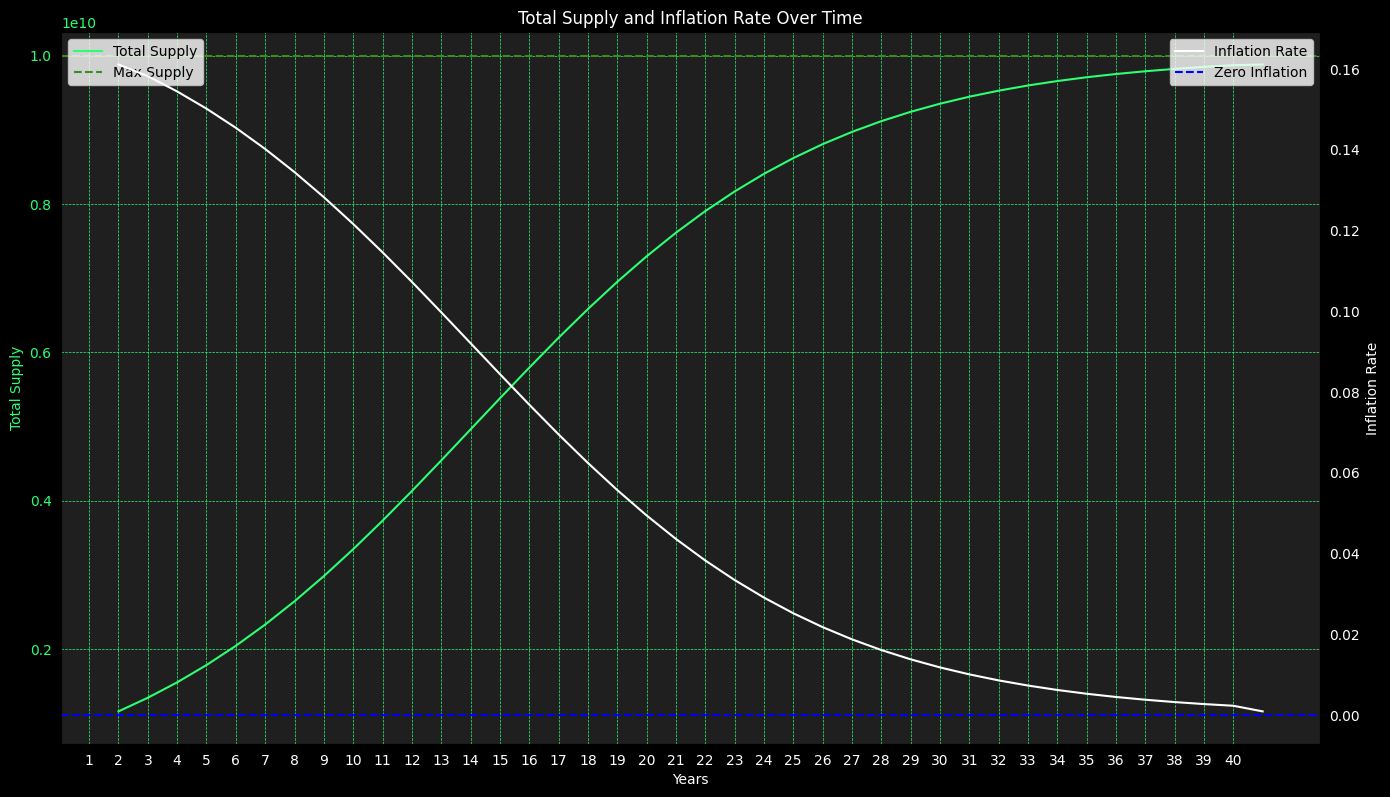

In [36]:
time_horizon, interval = 480, "annually"
df = create_emission_schedule_df(initial_supply, max_supply, daily_inflation_decay_constant, time_horizon, tge_date)
agg_df = aggregate_data(df, interval)
plot_supply_and_inflation(agg_df, interval)

In [39]:
# Interactive plot function
def interactive_plot(tge_date, daily_inflation_decay_constant, time_horizon, interval):
    df = create_emission_schedule_df(initial_supply, max_supply, daily_inflation_decay_constant, time_horizon, tge_date)
    agg_df = aggregate_data(df, interval)
    plot_supply_and_inflation(agg_df, interval)

# Interactive widgets
interact(interactive_plot,
         tge_date = DatePicker(value=tge_date, description='TGE Date'),
         daily_inflation_decay_constant = FloatSlider(value=daily_inflation_decay_constant, min=0.0004, max=0.01, step=0.00001, description='Daily Decay Constant'),
         time_horizon = FloatSlider(value=180, min=1, max=480, step=1, description='Time Horizon (months)'),
         interval = Dropdown(options=['daily', 'monthly', 'annually'], value='monthly', description='Interval')
        )

interactive(children=(DatePicker(value=datetime.datetime(2024, 9, 1, 0, 0), description='TGE Date', step=1), F…

<function __main__.interactive_plot(tge_date, daily_inflation_decay_constant, time_horizon, interval)>